In [1]:
%matplotlib inline
import numpy as np

from betaburst.detection.burst_detection import TfBursts

from neurodsp.sim import sim_powerlaw
from neurodsp.utils import set_random_seed, create_times

import matplotlib.pyplot as plt



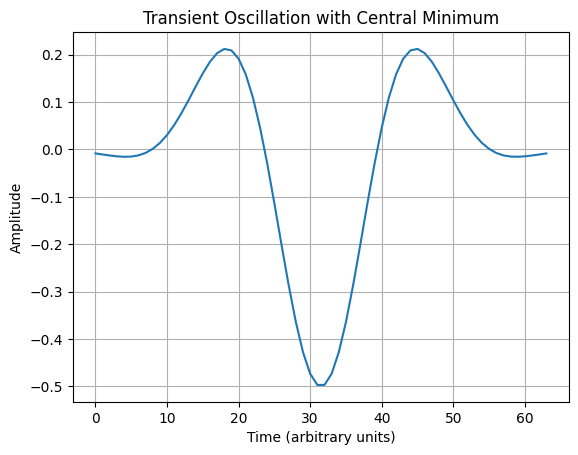

In [2]:
def generate_transient_minimum(w_size, freq=1, amplitude=0.5, decay=0.002):
    """
    Generate a transient oscillation with a clear local minimum at the center.

    Parameters:
        w_size (int): The size of the window (number of data points).
        freq (float): The frequency of the oscillation (controls how many oscillations occur).
        amplitude (float): The amplitude of the oscillation.
        decay (float): Decay factor for the transient effect.

    Returns:
        np.ndarray: Array containing the transient oscillation with a minimum at the center.
    """
    # Time vector centered around zero
    t = np.linspace(-1, 1, w_size)

    # Oscillatory part (inverted cosine wave) ensuring a minimum at the center
    oscillation = -amplitude * np.cos(2 * np.pi * freq * t)

    # Apply a Gaussian window to create the transient effect
    window = np.exp(-decay * (t * w_size) ** 2)

    # Combine the oscillation and the window
    transient_oscillation = oscillation * window

    return transient_oscillation


# Example usage
w_size = 64
signal = generate_transient_minimum(w_size, decay=0.001)

# Plot the result
plt.plot(signal)
plt.title("Transient Oscillation with Central Minimum")
plt.xlabel("Time (arbitrary units)")
plt.ylabel("Amplitude")
plt.grid(True)

#### Generate random background noise

In [3]:
np.random.seed(42)

# Simulation settings
fs = 250
n_epochs = 100
n_seconds = n_epochs * 2 * 5
exponent = -1
sig = sim_powerlaw(n_seconds, fs, exponent, f_range=(1, None))
times = create_times(n_seconds, fs)
epochs = sig.reshape((n_epochs, 2, 5 * fs)) / 5  # MNE format: (epoch, channel, trial)


print(np.max(epochs))
print(np.min(epochs))
f_stim = 15
length = 0.16
w_size = int(length * fs)
t = np.arange(0, length, 1 / fs)

0.8683103060760777
-0.9781678649487408


#### Insert bursts

In [4]:
for epochs_idx in range(n_epochs):
    for _ in range(3):
        coin = np.random.binomial(1, p=0.95)
        loc = np.random.uniform(0, 5 - length)
        if coin > 0:
            decay = np.random.uniform(0.001, 0.008)
            epochs[epochs_idx, 0, int(loc * fs) : int((loc + length) * fs)] = (
                7 * generate_transient_minimum(w_size, decay=decay)
            )
        else:
            std_stim = np.random.uniform(-5, 10)
            epochs[epochs_idx, 0, int(loc * fs) : int((loc + length) * fs)] = (
                2 * np.sin(2 * np.pi * t * (f_stim + std_stim))
            )

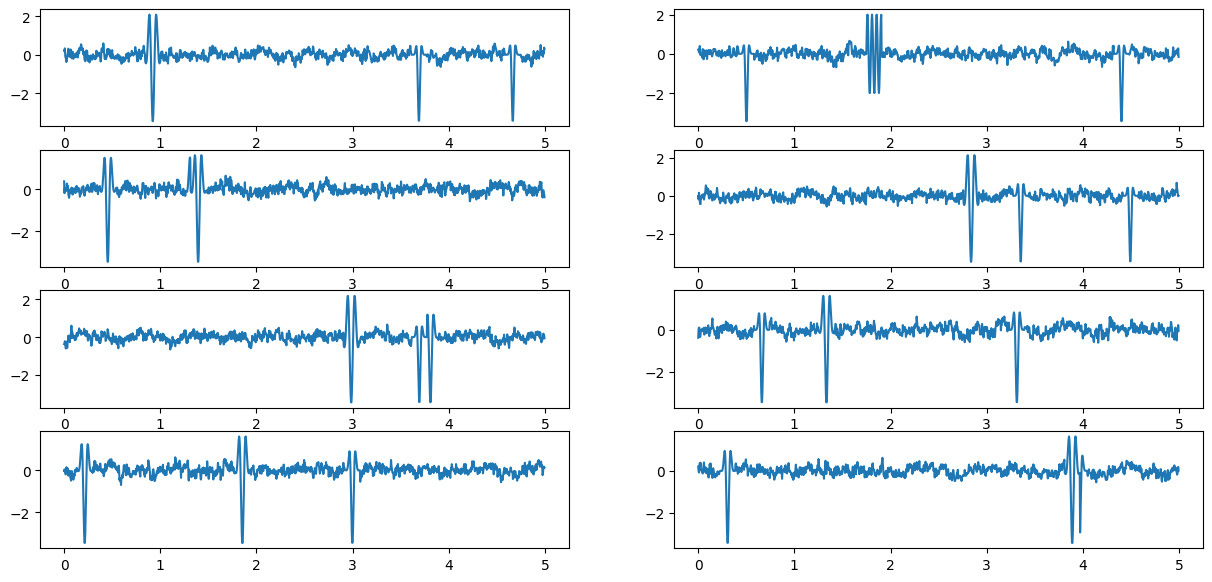

In [5]:
plt.figure(figsize=(15, 7))
plt.subplot(4, 2, 1)
plt.plot(np.arange(0, 5, 1 / fs), epochs[0, 0, :])
plt.subplot(4, 2, 2)
plt.plot(np.arange(0, 5, 1 / fs), epochs[4, 0, :])
plt.subplot(4, 2, 3)
plt.plot(np.arange(0, 5, 1 / fs), epochs[2, 0, :])
plt.subplot(4, 2, 4)
plt.plot(np.arange(0, 5, 1 / fs), epochs[8, 0, :])


plt.subplot(4, 2, 5)
plt.plot(np.arange(0, 5, 1 / fs), epochs[1, 0, :])
plt.subplot(4, 2, 6)
plt.plot(np.arange(0, 5, 1 / fs), epochs[5, 0, :])
plt.subplot(4, 2, 7)
plt.plot(np.arange(0, 5, 1 / fs), epochs[3, 0, :])
plt.subplot(4, 2, 8)
plt.plot(np.arange(0, 5, 1 / fs), epochs[9, 0, :])

### Time-frequency decomposition

In [6]:
freq_step = 0.5
freqs = np.arange(5.0, 47.0, freq_step)
upto_gamma_band = np.array([8, 40])
upto_gamma_range = np.where(
    np.logical_and(freqs >= upto_gamma_band[0], freqs <= upto_gamma_band[1])
)[0]

bm = TfBursts(
    fs,
    tmin=0,
    tmax=5,
    freqs=freqs,
    fr_band=upto_gamma_band,
    band_search_range=upto_gamma_range,
    band_limits=[8, 10, 35],
    remove_fooof=False,
)

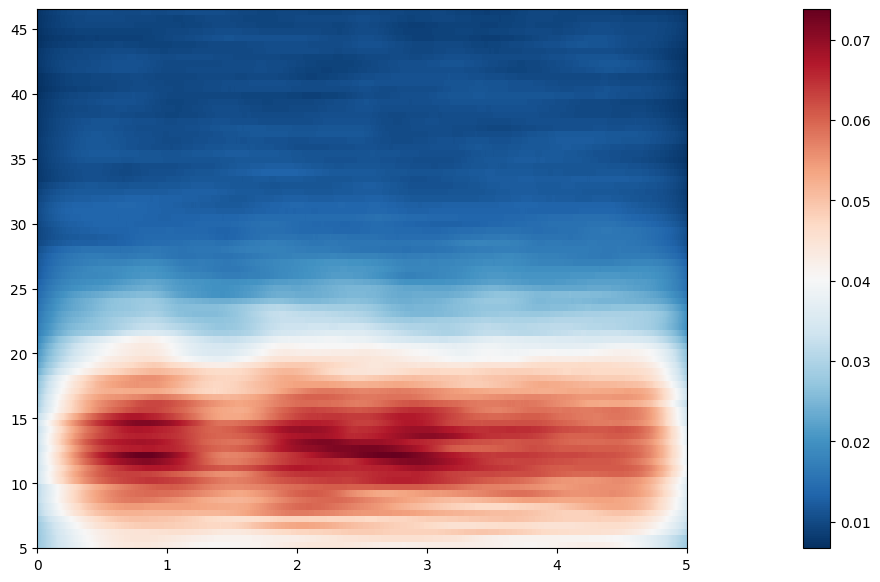

In [7]:
tfs = bm._apply_tf(epochs)
av_psds = np.mean(tfs, axis=0)
plt.figure(figsize=(30, 7))
plt.imshow(
    av_psds[0, :, :],
    aspect=1 / 10,
    cmap="RdBu_r",
    interpolation="none",
    origin="lower",
    extent=[0, epochs.shape[2] / fs, freqs[0], freqs[-1]],
)
plt.colorbar()

### Extract bursts

In [8]:
bursts = bm.burst_extraction(epochs, band="beta", std_noise=4)

Initiating beta band burst extraction without aperiodic activity subtraction...
	Burst extraction for all channels: from 10 to 35 Hz.


In [9]:
bursts[0].keys()

dict_keys(['channel', 'trial', 'waveform', 'peak_freq', 'peak_amp_iter', 'peak_amp_base', 'peak_time', 'peak_adjustment', 'fwhm_freq', 'fwhm_time', 'polarity', 'volume', 'waveform_times'])

#### Plot the bursts with the bigger amplitude

2346


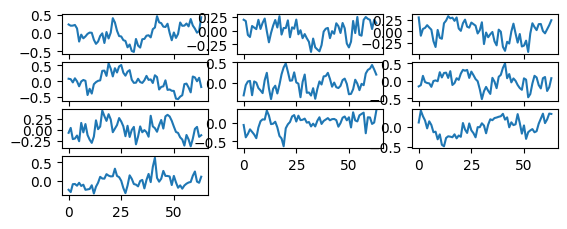

In [10]:
bigger = np.argsort(bursts[0]["peak_amp_iter"])[::-1][:30]
nb_bursts = len(bursts[1]["waveform"])
print(nb_bursts)
bigger_ch2 = np.argsort(bursts[1]["peak_amp_iter"])[::-1][:10]
for idx, burst in enumerate(bursts[1]["waveform"][bigger_ch2]):
    plt.subplot(8, 3, idx + 1)
    plt.plot(burst)

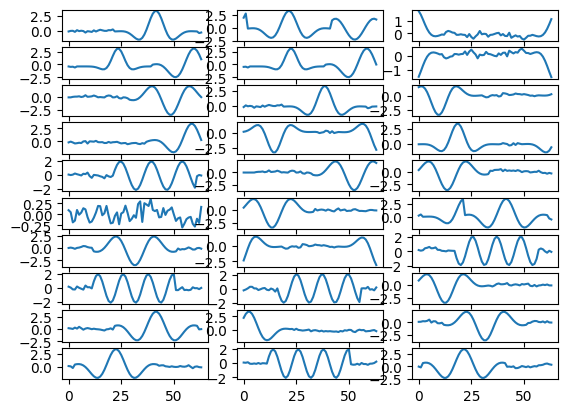

In [11]:
nb_bursts = len(bursts[0]["waveform"])
for idx, burst in enumerate(bursts[0]["waveform"][bigger]):
    plt.subplot(10, 3, idx + 1)
    plt.plot(burst)

## Waveforms shape analysis

In [12]:
from betaburst.analysis.burst_analysis import BurstSpace

bs = BurstSpace(perc=0.5, nb_quartiles=10, tmin=0, tmax=5, time_step=0.2)

Concatenating bursts along the different channels...


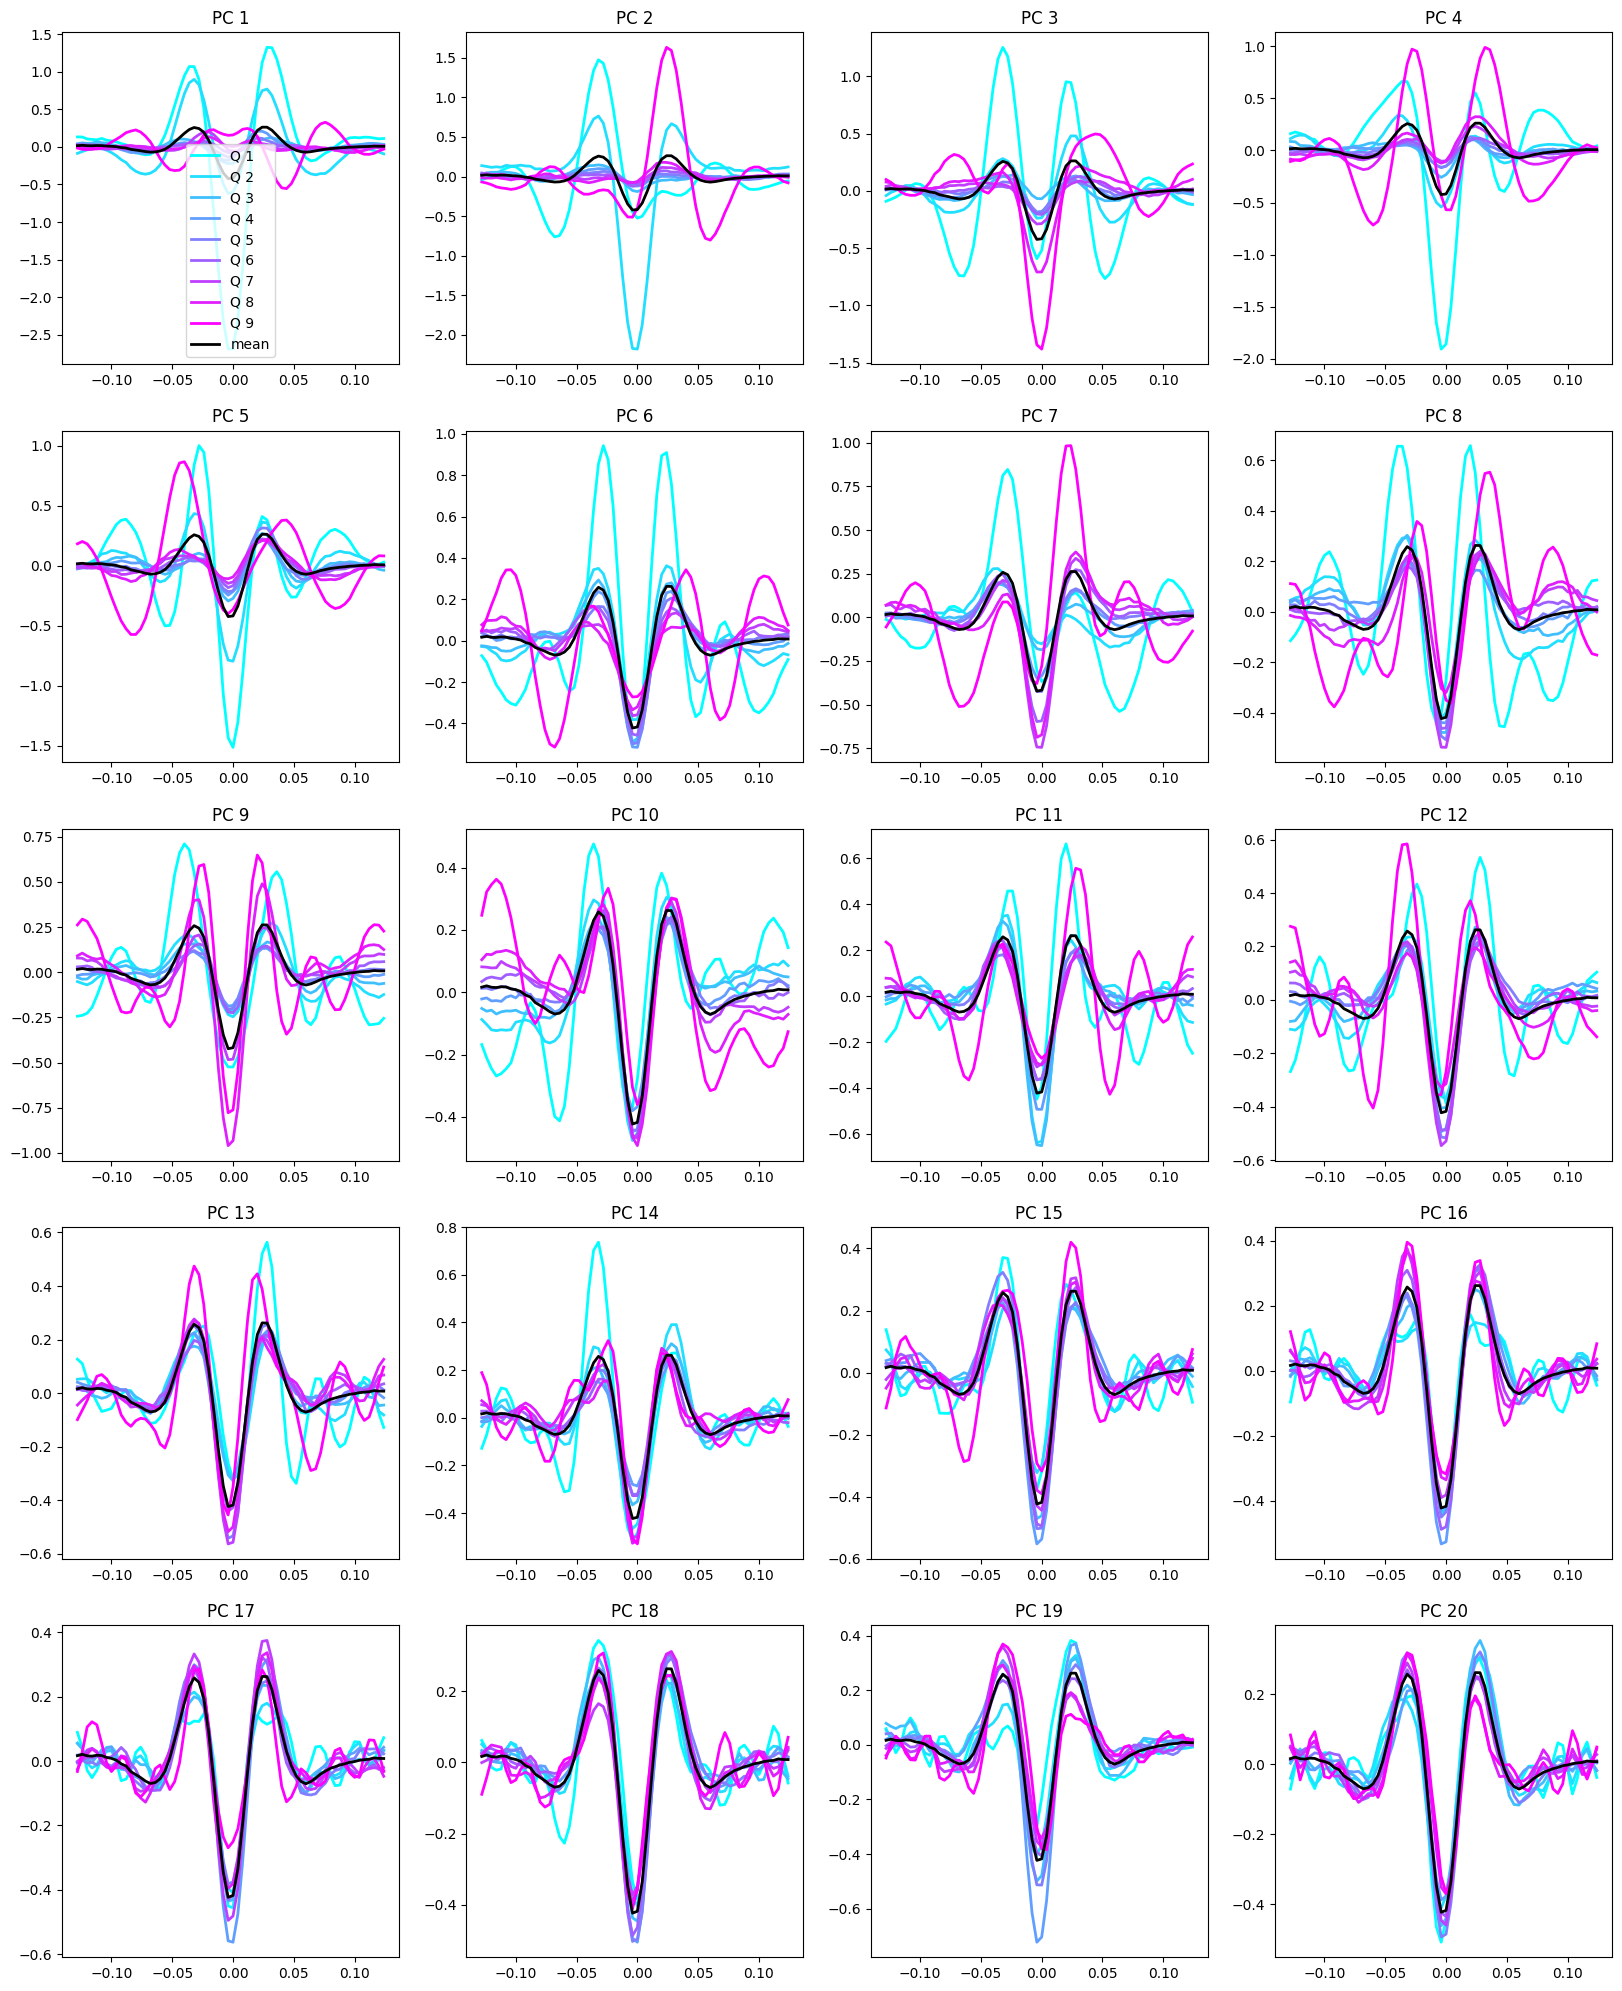

In [13]:
scores_dists = bs.fit_transform(bursts)
bs.plot_waveforms()

c:\Users\ludov\.conda\envs\embed\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\ludov\.conda\envs\embed\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


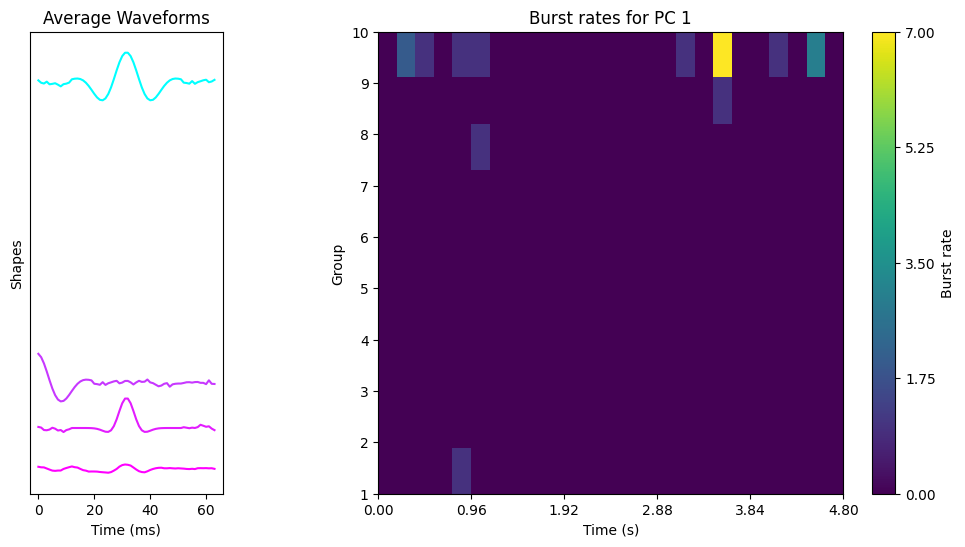

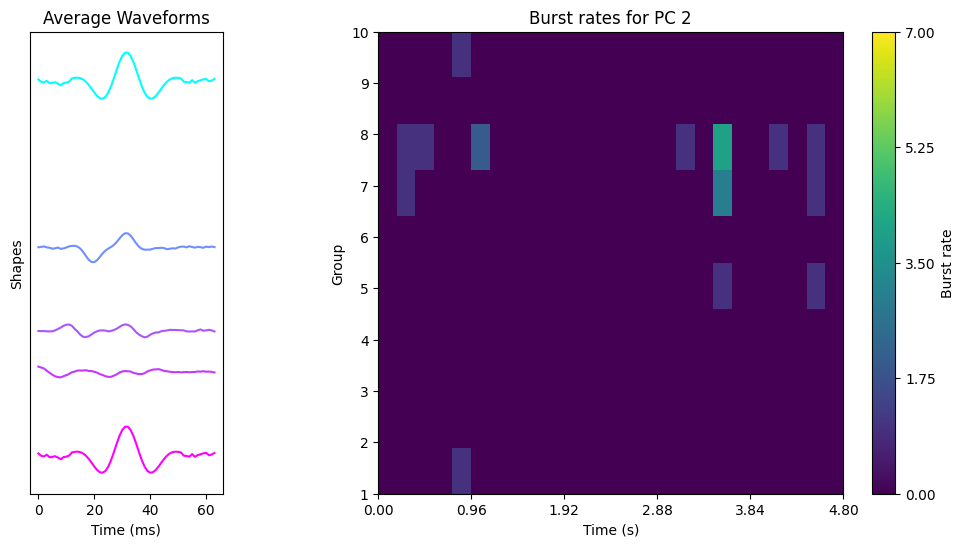

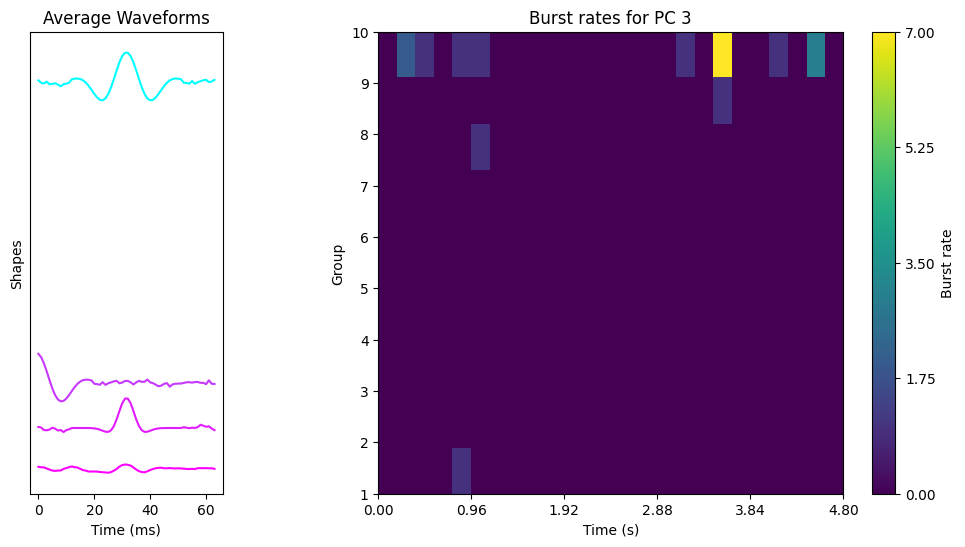

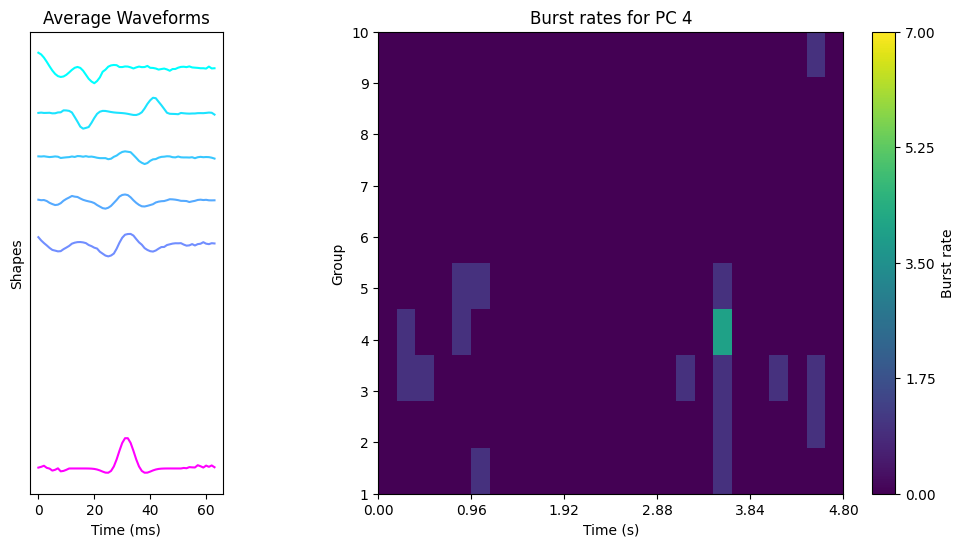

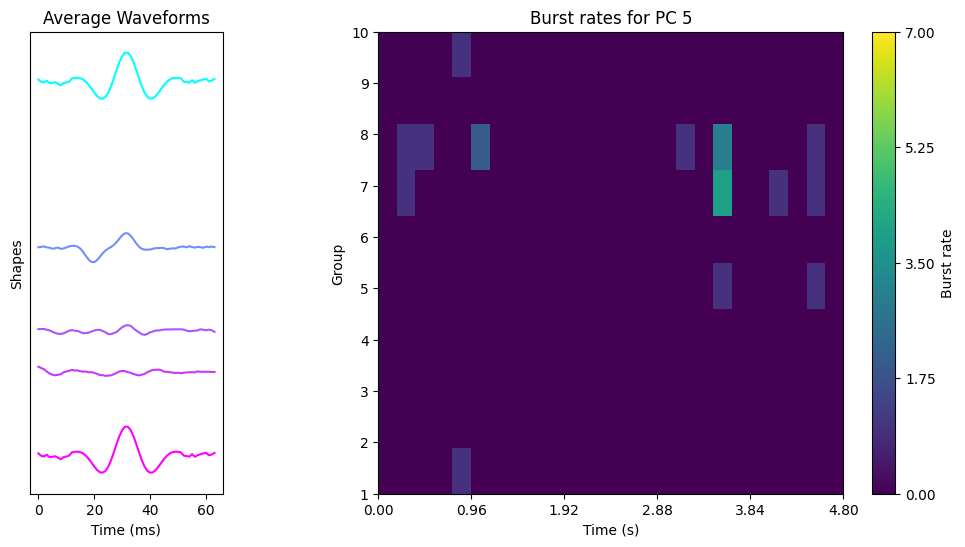

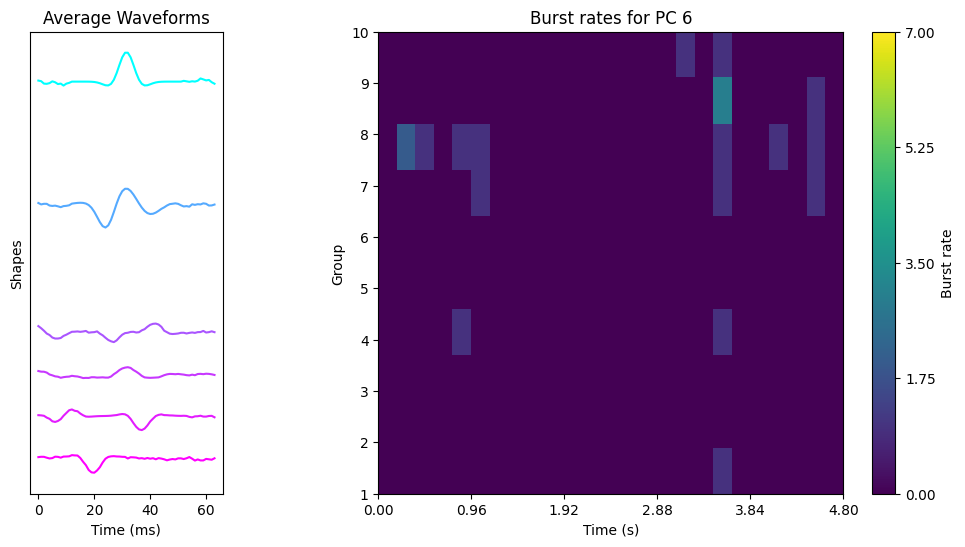

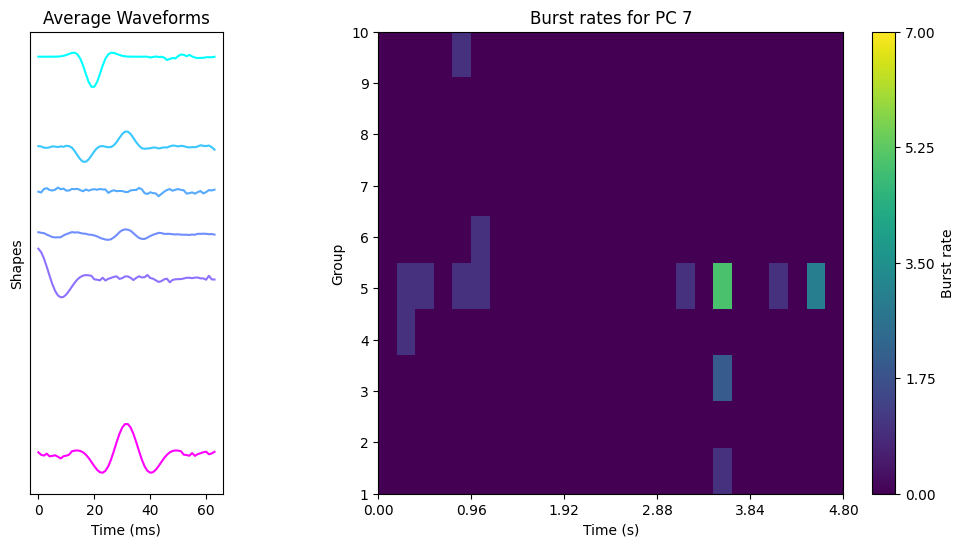

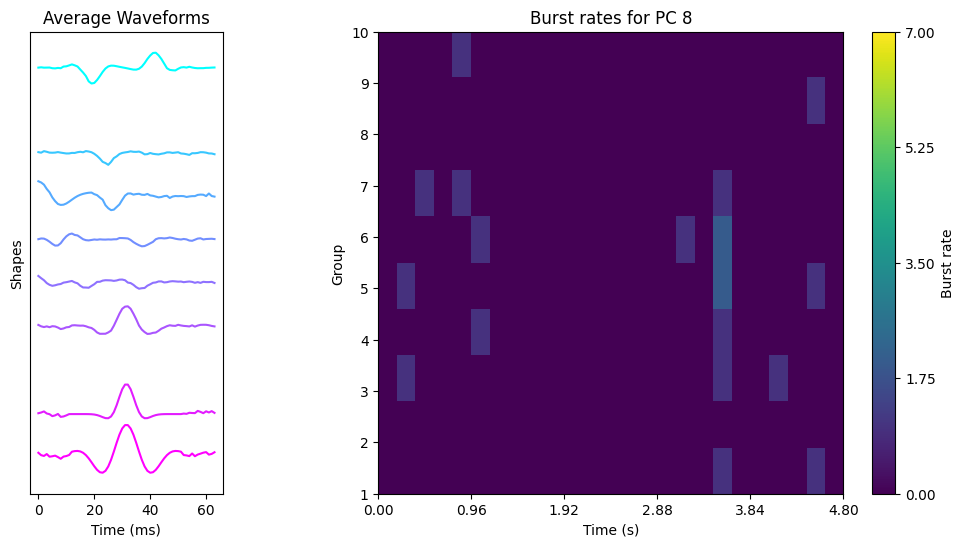

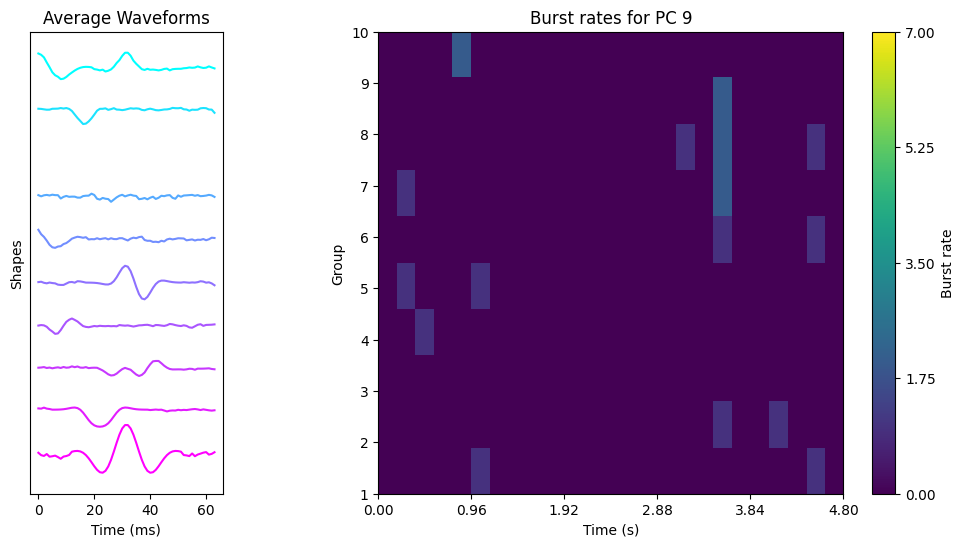

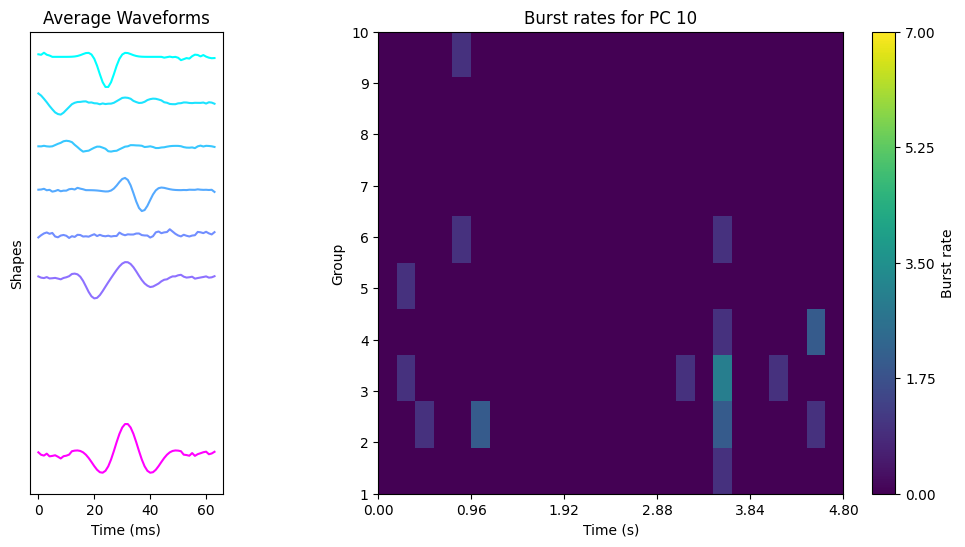

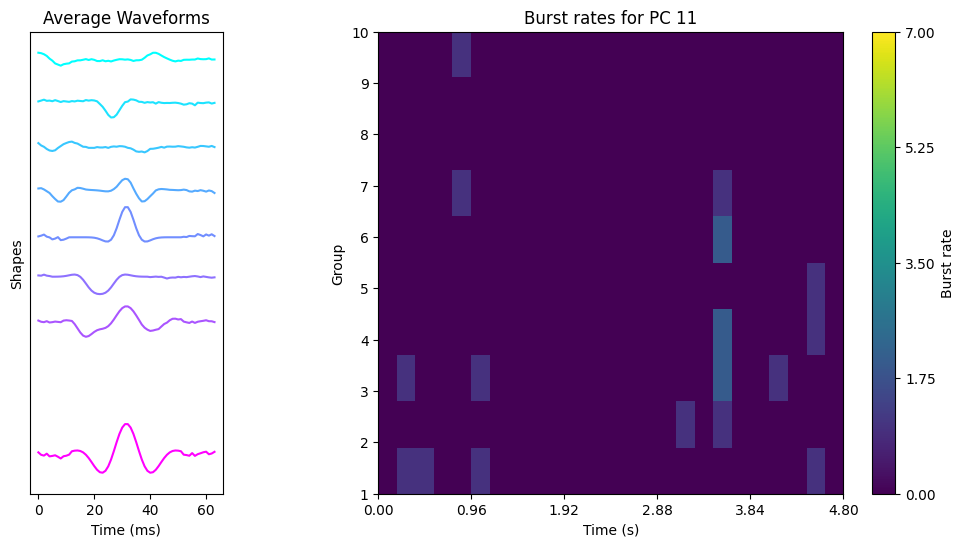

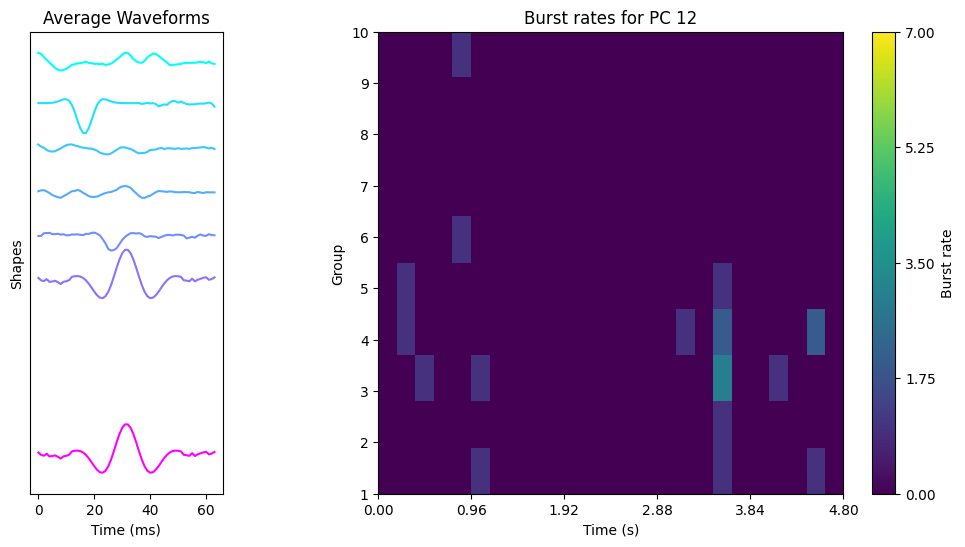

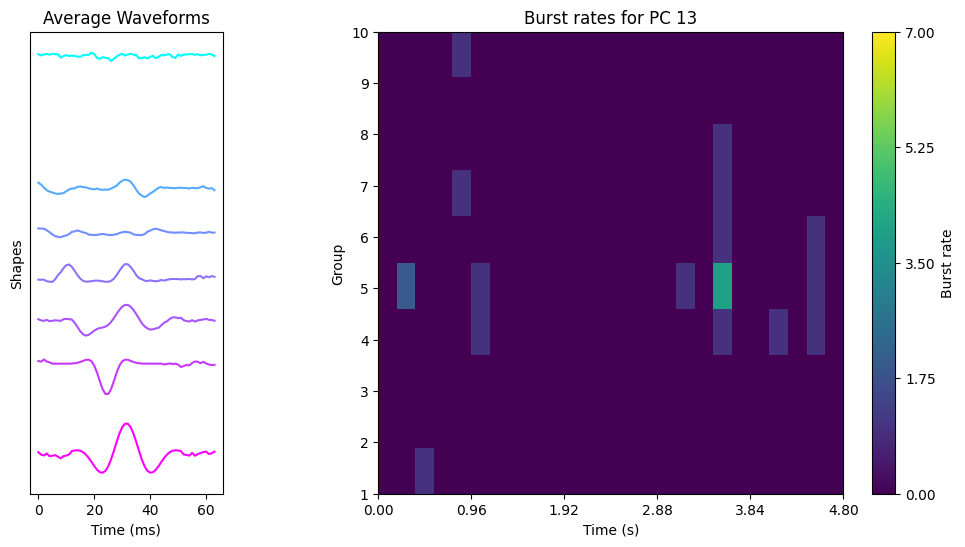

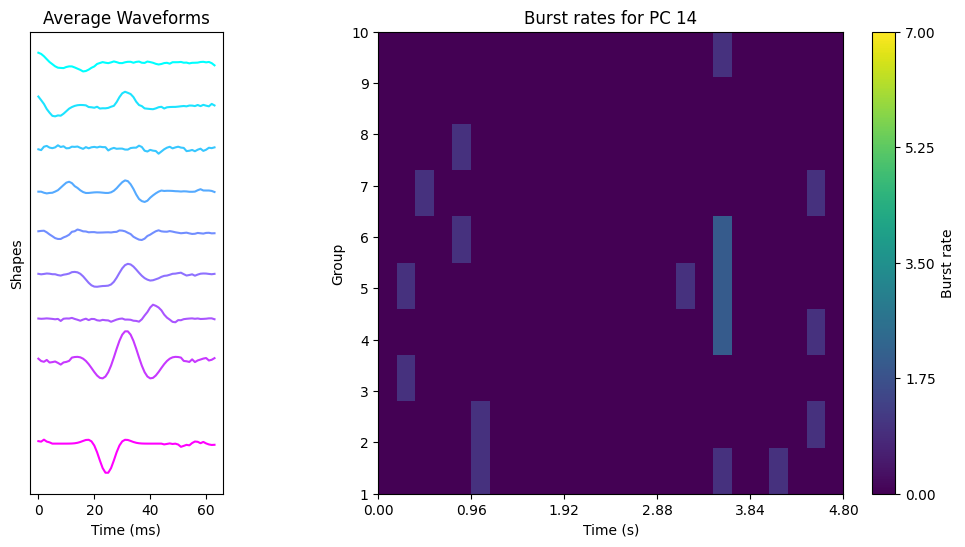

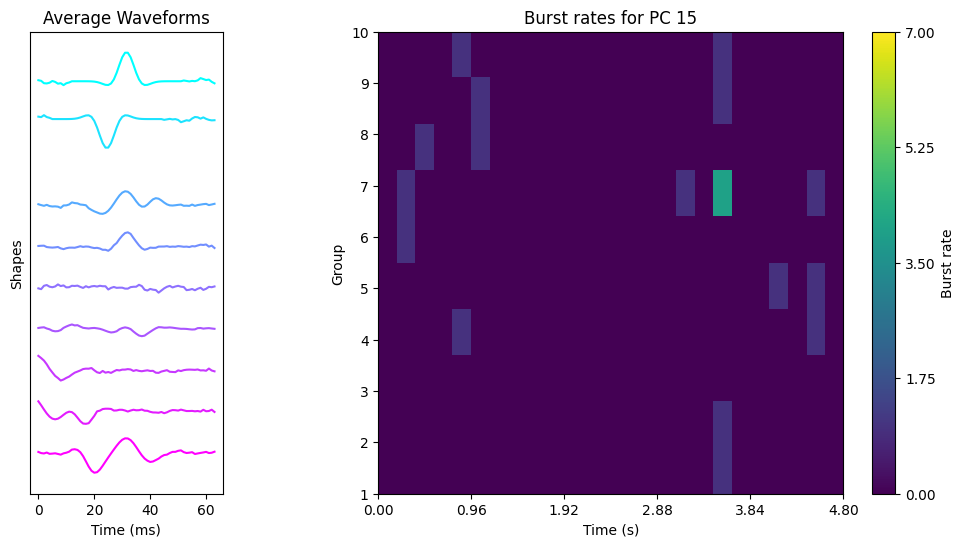

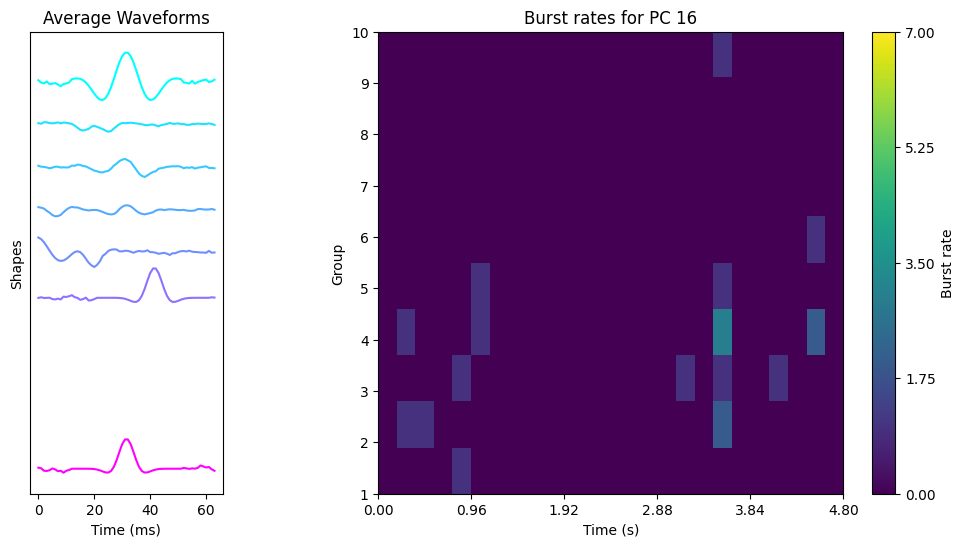

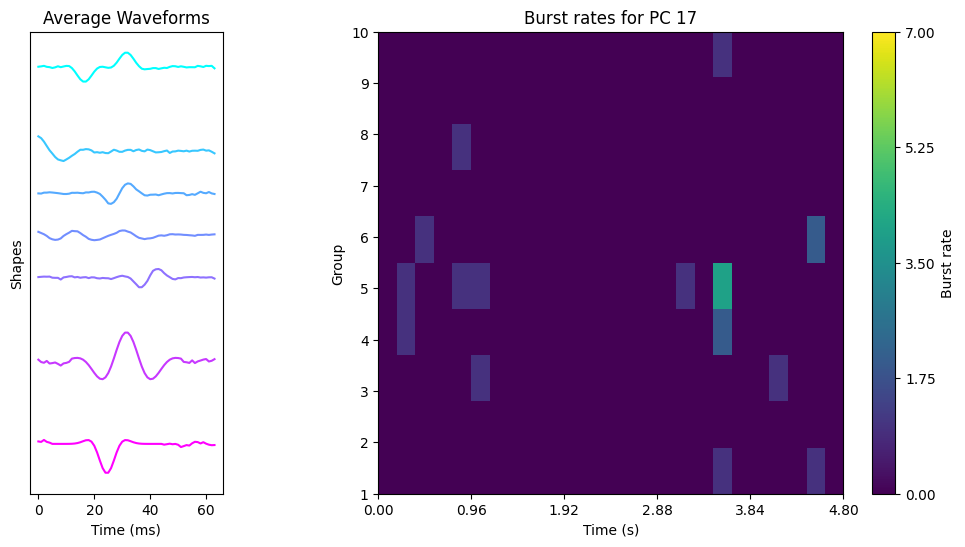

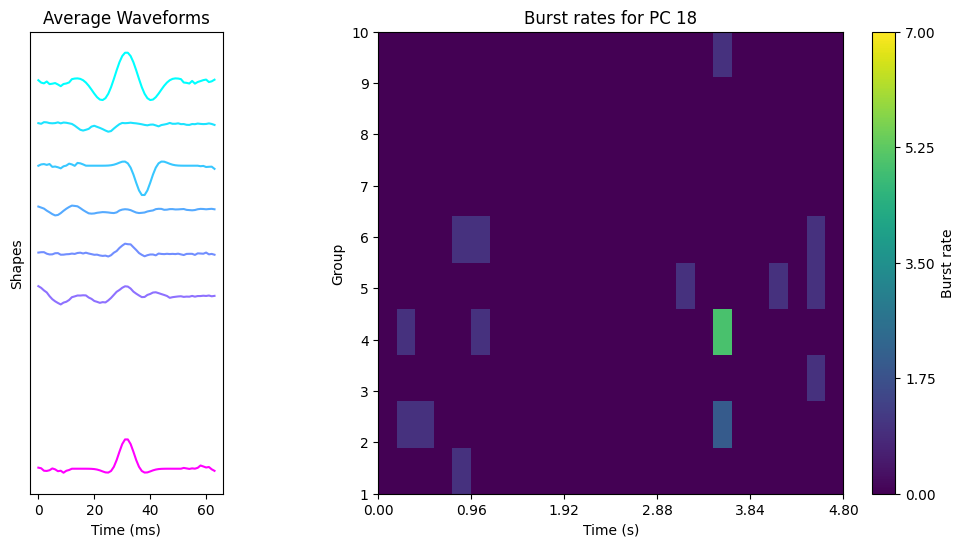

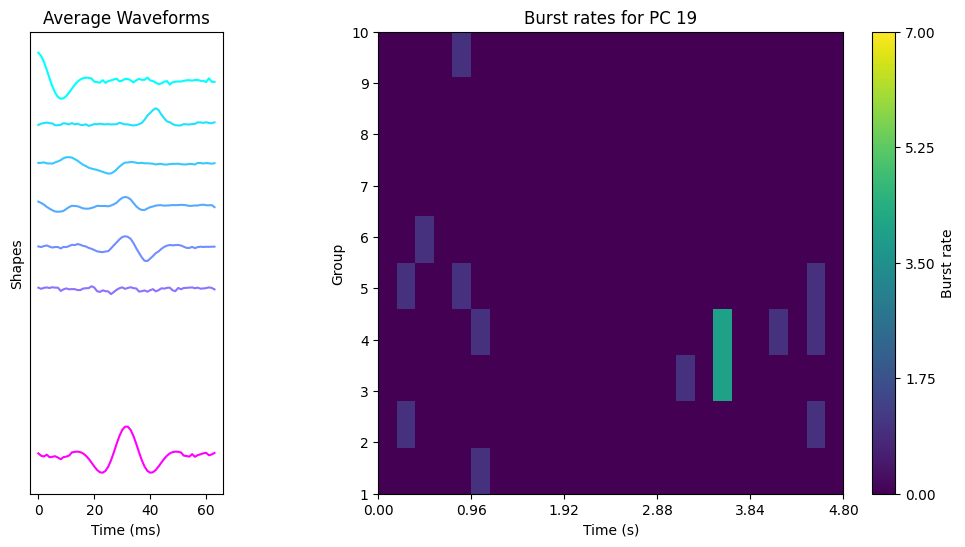

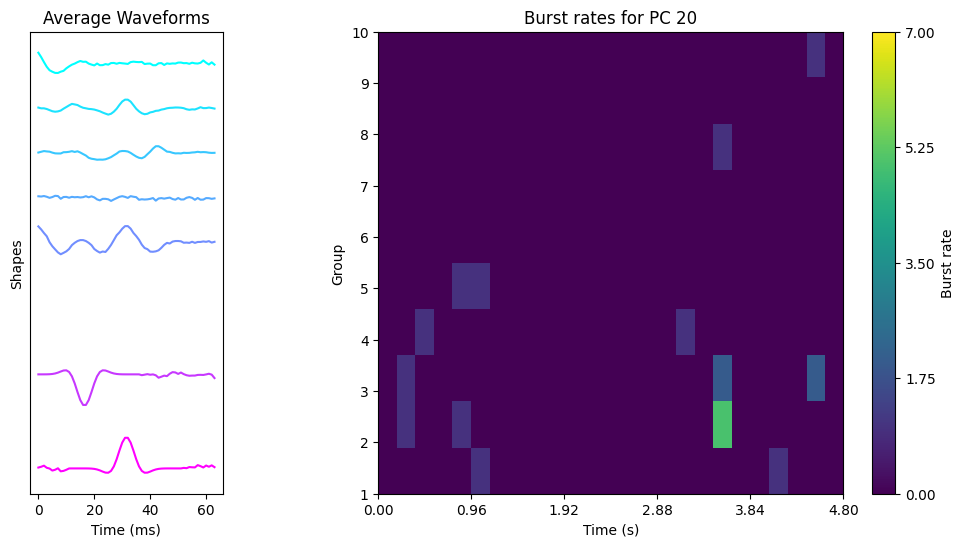

In [14]:
bs.plot_burst_rates()